## *Outline*

1.  Reading and exploring data
1.  Handling missing values
1.  Further data precrocessing for modeling
1.  Create predictive models ( Comparison between 4 different models )
1.  Results, notes and final decision.

In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dtt
from sklearn.metrics import roc_curve , roc_auc_score 
from sklearn.metrics import classification_report ,confusion_matrix , precision_score , recall_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/task-1/submission_test_set.csv
/kaggle/input/task-1/train_label.csv
/kaggle/input/predictive-maintenance/test_label_sample.csv
/kaggle/input/predictive-maintenance/feature.xlsx
/kaggle/input/predictive-maintenance/train_label.csv


# 1.Reading and exploring data

In [118]:
# processing features "training data"
X= pd.read_excel('/kaggle/input/predictive-maintenance/feature.xlsx')

# Exluding the header row from the dataframe
new_col = X.iloc[0]
X= X.iloc[1:]
X.columns= new_col

# Change format to datetime yyyy-mm-dd
X['date']= pd.to_datetime(X['date'],format='%d/%m/%Y')

# Removing id column
X= X.iloc[:,1:] 
print("size of training data:" ,X.shape)
X.head()

size of training data: (983, 131)


,date,136088194,136088202,136088394,136088802,136089546,136110468,136216674,136222202,136222210,...,136225010.0,136675426.0,136675626.0,136676578.0,136676650.0,136676666.0,136676682.0,136676698.0,136676714.0,136676754.0
1,2015-05-03,0,0,0,0,1,504,0,2,8,...,9056.261199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-05-04,0,0,0,0,0,2250,0,1,2,...,25402.087770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-05-05,0,0,0,0,0,1700,0,2,5,...,13609.724304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-05-06,0,0,0,0,0,2261,0,10,7,...,26122.640408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-05-07,0,0,0,0,0,2950,0,5,8,...,25499.201836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Check if there's categorical features
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 1 to 983
Columns: 131 entries, date to 136676754.0
dtypes: datetime64[ns](1), float64(103), int64(26), object(1)
memory usage: 1006.2+ KB


In [120]:
# processing target label
y= pd.read_csv('/kaggle/input/task-1/train_label.csv')
y['date']= pd.to_datetime(y['date'],format='%d/%m/%Y') 
print("number of target variables in training data:" ,y.shape)
y.head()

number of target variables in training data: (514, 2)


,date,label
0,2015-05-03,NaN
1,2015-05-04,0.0
2,2015-05-05,0.0
3,2015-05-06,0.0
4,2015-05-07,0.0


Text(0.5, 0, 'Date')

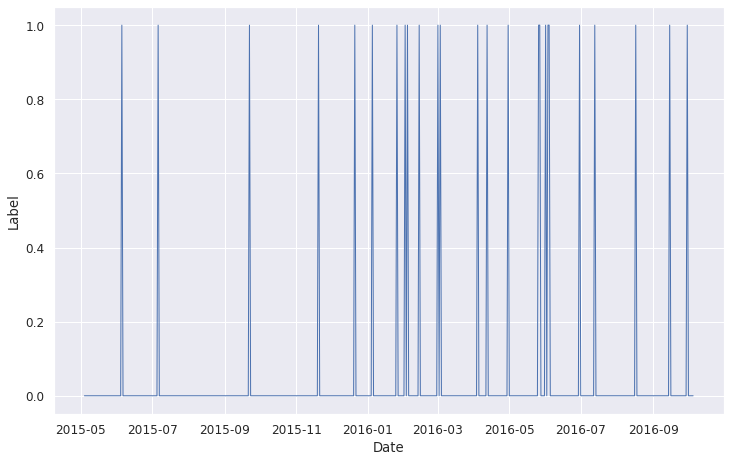

In [121]:
#Plotting target variable vs time

fig = plt.gcf()
fig.set_size_inches(12, 7.5)

plt.plot(y['date'] , y['label'], lw=1)
plt.ylabel('Label')
plt.xlabel('Date')

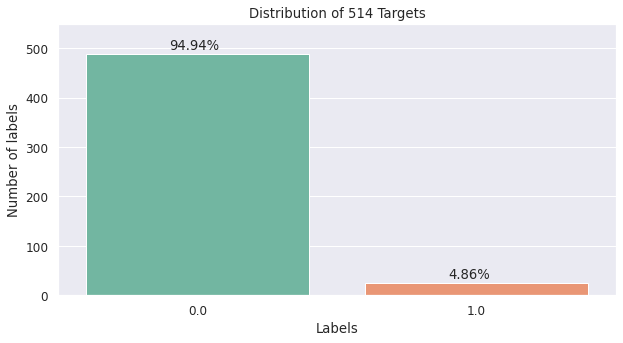

In [122]:
# Visulaize distrubtion of label data to determine data balance/imbalanced
ax = sns.countplot(x = y['label'] ,palette="Set2")
sns.set(font_scale=1.1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top= 550)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(y['label'])), (p.get_x()+ 0.3, p.get_height()+10))

plt.title('Distribution of 514 Targets')
plt.xlabel('Labels')
plt.ylabel('Number of labels')
plt.show()

# 2. Handling missing values

In [123]:
# Calculate number of missing values in y
y.isnull().sum()

date     0
label    1
dtype: int64

In [124]:
# Impute label missing value with the most frequently label 
frequent_label = y['label'].value_counts().index[0]
y['label']= y['label'].fillna(frequent_label)

# Validate if there's any missing values
y.isnull().any()

date     False
label    False
dtype: bool

In [125]:
# missing values percentage of the total dataset
total = X.isnull().sum().sort_values(ascending=False)
percent = np.round(((X.isnull().sum()/X.isnull().count())*100),2).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing %'])
missing_data.head()

,Total,Percent missing %
0,,
136675626.0,983,100.0
136675626.0,983,100.0
136675626.0,983,100.0
136675626.0,983,100.0
136222250.0,982,99.9


- There's three approaches to handle this large number of missing values:

1- We'll consider that when more than 30% of the data is missing, we should delete the corresponding variable. This means that we will not try any trick to fill the missing data in these cases.

2- The biggest share of missing values comes from min,max and std columns.So, in this approach we will use count features as our main training features because they have useful information.

3- Fill all missing values with zero using fillna(0) "not practical"

**We will go with the 1st approach**

In [126]:
# Drop missing variables in features ( more than 60% missing data )
X = X.drop(missing_data[missing_data["Percent missing %"] > 60].index,1)
print("The new number of features is :" , X.shape[1])

The new number of features is : 21


In [127]:
# Renaming features to be used for handling missing values
features_names =  [ 'date' , 'f1' , 'f2' , 'f3' , 'f4' , 'f5' , 'f6' , 'f7' , 'f8' , 'f9' , 'f10', 'f11' , 'f12' ,
                   'f13' , 'f14' , 'f15' , 'f16' , 'f17' , 'f18' , 'f19' , 'f20' ]
X.columns = features_names
X.head()

,date,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
1,2015-05-03,504,2,8,189,85143.0,NaN,83458.0,85428.0,57219.0,...,62482.0,57300.0,62511.267857,NaN,72762.750000,69708.158730,2649.266694,NaN,8497.660027,9056.261199
2,2015-05-04,2250,1,2,894,78654.0,NaN,NaN,85968.0,13460.0,...,NaN,922.0,53031.172889,NaN,NaN,58346.875839,25382.115201,NaN,NaN,25402.087770
3,2015-05-05,1700,2,5,2421,78651.0,NaN,78637.0,84193.0,9719.0,...,14846.0,60.0,40999.581176,NaN,53638.000000,14103.926064,15378.363707,NaN,23582.198063,13609.724304
4,2015-05-06,2261,12,7,364,74104.0,69169.0,74085.0,83761.0,5719.0,...,5712.0,479.0,44931.727996,60727.75,46783.571429,47695.115385,23820.594001,15442.674875,30959.472535,26122.640408
5,2015-05-07,2950,5,10,461,67653.0,67517.0,67649.0,85082.0,2726.0,...,38575.0,577.0,48090.756610,55276.00,60013.600000,41987.863341,15053.402791,19950.847250,11489.918946,25499.201836


- After having named 21 features, we will check if there are categorical feature, so we will convert it to numerical for our model

In [128]:
X.dtypes.unique()

array([dtype('<M8[ns]'), dtype('int64'), dtype('float64')], dtype=object)

No categorical data exists for the remaining features, so no label encoding or type casting needed

In [129]:
# Check missing values again
X.isnull().sum().sort_values(ascending=False).head(20)

f11    557
f7     557
f15    557
f19    557
f20    536
f16    536
f8     536
f12    536
f6     512
f10    512
f14    512
f18    512
f13     80
f9      80
f17     80
f5      80
f4       0
f3       0
f2       0
f1       0
dtype: int64

In [130]:
# All missing values will be fillied with the corresponding column mean value

missing_features =  [ 'f5' , 'f6' , 'f7' , 'f8' , 'f9' , 'f10', 'f11' , 'f12' ,'f13' ,
                      'f14' , 'f15' , 'f16' , 'f17' , 'f18' , 'f19' , 'f20' ]

for col in missing_features:
    X[col] = X[col].fillna(X[col].mean())

In [131]:
# Verify that all missing values are handled
print("Number of missing values remainig:" , X.isnull().any().sum() )

Number of missing values remainig: 0


In [132]:
X.head()

,date,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
1,2015-05-03,504,2,8,189,85143.0,69303.609342,83458.000000,85428.0,57219.0,...,62482.000000,57300.0,62511.267857,43003.692658,72762.750000,69708.158730,2649.266694,20937.894341,8497.660027,9056.261199
2,2015-05-04,2250,1,2,894,78654.0,69303.609342,68184.387324,85968.0,13460.0,...,16244.046948,922.0,53031.172889,43003.692658,42769.902406,58346.875839,25382.115201,20937.894341,18583.404629,25402.087770
3,2015-05-05,1700,2,5,2421,78651.0,69303.609342,78637.000000,84193.0,9719.0,...,14846.000000,60.0,40999.581176,43003.692658,53638.000000,14103.926064,15378.363707,20937.894341,23582.198063,13609.724304
4,2015-05-06,2261,12,7,364,74104.0,69169.000000,74085.000000,83761.0,5719.0,...,5712.000000,479.0,44931.727996,60727.750000,46783.571429,47695.115385,23820.594001,15442.674875,30959.472535,26122.640408
5,2015-05-07,2950,5,10,461,67653.0,67517.000000,67649.000000,85082.0,2726.0,...,38575.000000,577.0,48090.756610,55276.000000,60013.600000,41987.863341,15053.402791,19950.847250,11489.918946,25499.201836


# 3. Further preprocessing

- Since labels and features are in different files, we will concatunate X and y dataframes by the same observations 'date'

In [133]:
# Getting training set data
# Merging training features and the corresponding label "1 or 0" by date
train_set = pd.merge(X, y, on='date')
train_set.tail()

,date,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,label
509,2016-10-01,4,2,3,2,78675.601329,69303.609342,68184.387324,76872.011186,7469.82392,...,9728.431767,43570.437050,43003.692658,42769.902406,43111.679213,22736.397501,20937.894341,18583.404629,21501.088761,0.0
510,2016-10-02,13,3,1,0,83103.000000,69303.609342,68184.387324,76872.011186,9854.00000,...,9728.431767,57874.692308,43003.692658,42769.902406,43111.679213,25684.714671,20937.894341,18583.404629,21501.088761,0.0
511,2016-10-03,15,1,11,10,81188.000000,69303.609342,83273.000000,81304.000000,7097.00000,...,11294.000000,35137.866667,43003.692658,39848.363636,57564.300000,20816.840150,20937.894341,19407.702127,24169.119683,0.0
512,2016-10-04,12,3,0,1,85787.000000,69303.609342,68184.387324,76872.011186,784.00000,...,9728.431767,49823.416667,43003.692658,42769.902406,43111.679213,24976.890564,20937.894341,18583.404629,21501.088761,0.0
513,2016-10-05,1,3,0,3,78675.601329,69303.609342,68184.387324,76872.011186,7469.82392,...,9728.431767,43570.437050,43003.692658,42769.902406,43111.679213,22736.397501,20937.894341,18583.404629,21501.088761,0.0


Text(0.5, 0, 'Date')

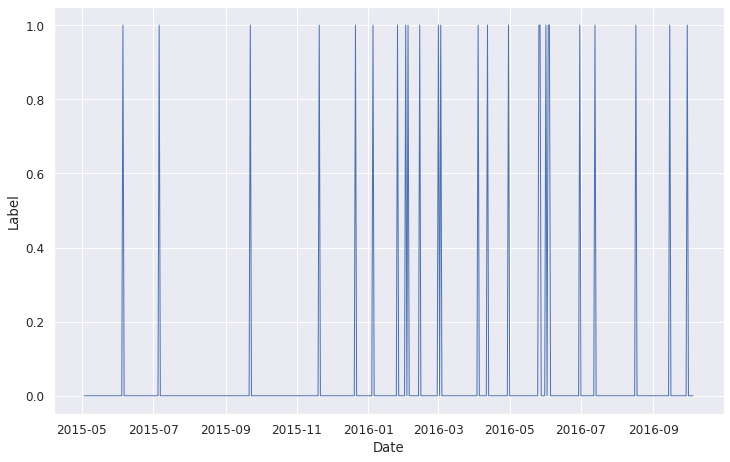

In [134]:
# plotting label vs time after preprocessing
fig = plt.gcf()
fig.set_size_inches(12, 7.5)

plt.plot(train_set['date'] , train_set['label'] , lw=1)
plt.ylabel('Label')
plt.xlabel('Date')

In [135]:
X_new= train_set.iloc[:,0:-1]
y_new= train_set['label']
print("shape of features X after preprocessing:" , X_new.shape)
print("shape of target variable y after preprocessing:" , y_new.shape)

shape of features X after preprocessing: (514, 21)
shape of target variable y after preprocessing: (514,)


# 4. Create predictive models

*     Weighted average Deceision Tree classifier 
*     Hypertuned Decision Tree with Grid search
*     Ensemble method "XGBoost"
*     Deep learning sequence model "LSTM"

### Decision Tree Classifier

In [136]:
# The function toordinal() returns the a numeric format "int type" of a date
# To be used in machine learning models 
X_new['date']=X_new['date'].map(dtt.datetime.toordinal)
X_new['date'].head()

0    735721
1    735722
2    735723
3    735724
4    735725
Name: date, dtype: int64

The decision tree algorithm is effective for binary classification, although it does not perform well on imbalanced datasets, so we will use Weighted Decision Tree With Scikit-Learn

In [137]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


dt = DecisionTreeClassifier(class_weight = {0:1.0, 1:10.0} , min_samples_leaf = 0.04)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(dt, X_new, y_new, scoring='roc_auc', cv=cv, n_jobs=-1)
# Fit the training set to the model
dt.fit(X_new, y_new)

# Predict on the test set
y_pred_prob_dt = dt.predict_proba(X_new)[:,1]

# summarize performance
roc_auc = roc_auc_score(y_new,y_pred_prob_dt)
print('ROC AUC for training set: %.3f' % roc_auc)

roc_cv= np.mean(scores)
print('ROC AUC for cross validation set: %.3f' % roc_cv )

ROC AUC for training set: 0.921
ROC AUC for cross validation set: 0.568


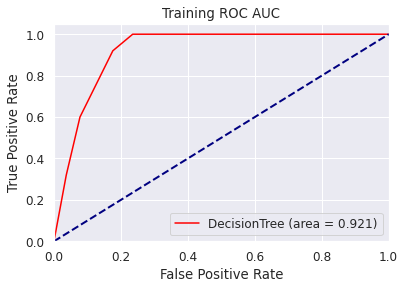

In [138]:
# plotting roc curve for cross validation set

# calculate the fpr and tpr for all thresholds of the classification
roc_auc = roc_auc_score(y_new,y_pred_prob_dt)
fpr, tpr, thresholds = roc_curve(y_new,y_pred_prob_dt)
plt.figure()

plt.plot(fpr, tpr, color='red', label='DecisionTree (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC AUC')
plt.legend(loc="lower right")

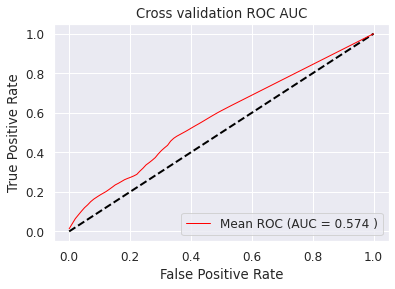

In [139]:
# plotting roc curve for cross validation set

from sklearn.metrics import auc

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_new,y_new):
    prediction = dt.fit(X_new.iloc[train],y_new.iloc[train]).predict_proba(X_new.iloc[test])
    fpr, tpr, t = roc_curve(y_new[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=1, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross validation ROC AUC')
plt.legend(loc="lower right")
plt.show()

###  Hypertuned Decision Tree with Grid Search

In [140]:
# Using GridSearch for hyperparameter tuning the decision tree
from sklearn.model_selection import GridSearchCV

dt2 = DecisionTreeClassifier()

params_dt = {
    'class_weight' : [{0:100,1:1}, {0:10,1:1}, {0:1,1:1} , {0:1,1:10} , {0:1,1:10}] ,
    'min_samples_leaf': [ 0.02 , 0.03 , .04 ],
    'max_features': [ 0.2 , 0.3 , 0.4]
}



# Instantiate a 7-fold Cross validation grid search object
grid_dt = GridSearchCV(estimator=dt2,
                        param_grid=params_dt,
                        scoring= 'roc_auc',
                        cv=7,
                        n_jobs=-1)

# Fit 'grid_dt' to the training set
grid_dt.fit(X_new, y_new)

# Show the best hyperparameters for the model
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'class_weight': {0: 1, 1: 10}, 'max_features': 0.4, 'min_samples_leaf': 0.03}


In [141]:
# Predict on the train set
y_pred_prob_grid_dt = grid_dt.predict_proba(X_new)[:,1]

# summarize performance
roc_auc_gd = roc_auc_score(y_new,y_pred_prob_grid_dt)
print('ROC AUC for training set: %.2f' % roc_auc_gd)

# Extract best CV score from 'grid_dt'
best_CV_score = grid_dt.best_score_

print('ROC AUC for cross validation set: %.2f' % best_CV_score)

ROC AUC for training set: 0.90
ROC AUC for cross validation set: 0.62


- Grid search plotting for cross validation will take a longer time, so we will only calculate the ROC improvement from untuned decision tree

In [168]:
roc_improvement = np.abs(best_CV_score - roc_cv) * 100
print('ROC AUC percentage improvement after Grid search: %.1f' % roc_improvement ,"%")

ROC AUC percentage improvement after Grid search: 5.2 %


- From the big difference in roc value in the training and validation set, we conclude that the model overfits the training data

- In general, decision trees are prone to overfitting so ensemble methods as gradient boosting will be used

## Ensemble Model "XGBoost"

In [144]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Transform data into DMatrix for XGboost 
dmatrix_train = xgb.DMatrix(data=X_scaled,label=y_new)

X_scaled= std_scaler.fit_transform(X_new)


# aplpha performs L1 regularization on leaf weights to reduce overfitting
params={"objective":'binary:logistic', 'alpha': 0.01 ,
        "max_depth":10 ,'subsample': 0.7,'gamma': 0.65, 'colsample_bytree': 0.8 }



# Transform data into DMatrix for XGboost 
dmatrix_train = xgb.DMatrix(data=X_scaled,label=y_new)

# 5 folds cross validation 
cv_results = xgb.cv(dtrain=dmatrix_train, params=params, nfold=5,
                    num_boost_round=100, metrics="auc", as_pandas=True)

best_xgbcv = cv_results["test-auc-mean"].max()
print('ROC AUC for XGB model: %.2f' %best_xgbcv )
xg_improvement = np.abs(best_xgbcv - best_CV_score) * 100
print(' XGBboost ROC AUC percentage improvement from tuned Decision tree: %.2f' % xg_improvement,"%")

ROC AUC for XGB model: 0.72
 XGBboost ROC AUC percentage improvement from tuned Decision tree: 9.85 %


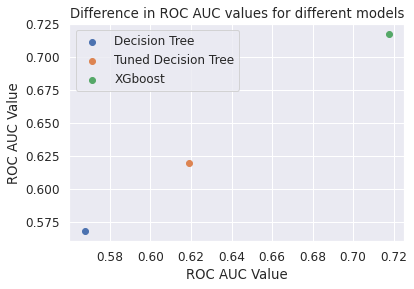

In [145]:
plt.scatter(roc_cv , roc_cv , label="Decision Tree")
plt.scatter([best_CV_score] , best_CV_score , label="Tuned Decision Tree")
plt.scatter([best_xgbcv], best_xgbcv , label="XGboost")
plt.xlabel('ROC AUC Value')
plt.ylabel('ROC AUC Value')
plt.title('Difference in ROC AUC values for different models')
plt.legend()

# XGBoost: Prediction on unseen data

In [146]:
# Extract test set data from features ( unlabeled date )
test_set = X.iloc[y.shape[0]:, :].reset_index(drop=True)
dates = test_set['date']

test_set['date']=test_set['date'].map(dtt.datetime.toordinal)

print("shape of training set is", X_new.shape ,
      " , shape of training set labels is" ,  y_new.shape)
print("shape of test set data is", test_set.shape)

shape of training set is (514, 21)  , shape of training set labels is (514,)
shape of test set data is (469, 21)


In [147]:
test_scaled = std_scaler.transform(test_set)
dmatrix_test = xgb.DMatrix(test_scaled)
mdl = xgb.train(params, dmatrix_train)
xgb_prob = mdl.predict(dmatrix_test, ntree_limit=mdl.best_ntree_limit)

In [166]:
# Create Dataframe for submission
submission = pd.DataFrame(columns=['date','probability'] )
submission['date'] = dates
submission['probability'] = xgb_prob
submission.head()

,date,probability
0,2016-10-06,0.087166
1,2016-10-07,0.043749
2,2016-10-08,0.086150
3,2016-10-09,0.092305
4,2016-10-10,0.083678


In [167]:
submission.to_csv('/kaggle/working/submission_test_set.csv', index = False)

___________________________________________________

## Deep learning sequence model "LSTM"

-  Critical advantage of LSTMs over traditional feature engineering approaches is their ability to remember from long-term sequences (window sizes)

- LSTM will make use of past machine errors over time to enhance prediction of future errors

Reference:
https://github.com/Azure-Samples/MachineLearningSamples-DeepLearningforPredictiveMaintenance

In [150]:
# Import kears libraries 
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [151]:
train_set # Collecting data before parsing the date
test_set = X.iloc[y_new.shape[0]:, :].reset_index(drop=True)
print("shape of training set with labels:",train_set.shape)
print("shape of test set:",test_set.shape)

shape of training set with labels: (514, 22)
shape of test set: (469, 21)


In [152]:
cols_to_keep =  ['f1' , 'f2' , 'f3' , 'f4' , 'f5' , 'f6' , 'f7' , 'f8' , 'f9' , 'f10', 'f11' , 'f12' ,
                   'f13' , 'f14' , 'f15' , 'f16' , 'f17' , 'f18' , 'f19' , 'f20' ]
target_label ='label'

In [153]:
# Unlike decision trees, data must be scaled to be used in the LSTM model
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler() # scaling each feature to a given range (0,1) by default

train_set[cols_to_keep]=scaler.fit_transform(train_set[cols_to_keep]) 
test_set[cols_to_keep]=scaler.transform(test_set[cols_to_keep])

LSTM keras layers expect an input in the shape of an array of 3 dimensions (samples, time steps, features) where 'time steps' is the look back window or sequence length and 'features' is the number of features of each sequence at each time step.

In [154]:
# gen_sequence function to reshape data into 3D dims (samples, time steps, features):

    # id_df: the number of training sequences
    # seq_length:  the look back window 
    # seq_cols: the number of features of each sequence at each time step.

def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [155]:
# gen_label function to generate label for every sequence:
    # id_df: the number of training sequences
    # seq_length:  the look back window 
    # seq_cols: the number of features of each sequence at each time step.
    # label: the label that we want to predict 0,1

def gen_label(id_df, seq_length, seq_cols ,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [156]:
# Generate sequences for the training data
sequence_length = 20

X_train=gen_sequence(train_set, sequence_length, cols_to_keep)
print("shape of traning sequences is:" , X_train.shape)
# generate y_train labels
y_train=gen_label(train_set, sequence_length, cols_to_keep,'label')
print("shape of traning labels for sequences is:" , y_train.shape)

# Generate sequences for the training set
X_test=gen_sequence(test_set, sequence_length, cols_to_keep)
print("shape of test set sequences is:" ,X_test.shape)

shape of traning sequences is: (513, 20, 20)
shape of traning labels for sequences is: (513,)
shape of test set sequences is: (468, 20, 20)


- Create LSTM model

In [157]:
n_features =X_train.shape[2] # access the 3rd index
timestamp=sequence_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, n_features),
         units=80,
         return_sequences=True))

# Add dropout to avoid overfitting 
model.add(Dropout(0.1))

model.add(LSTM(
          units=50,
          return_sequences=True))

model.add(Dropout(0.1))


model.add(LSTM(
          units=30,
          return_sequences=False))

model.add(Dropout(0.1))

# Using sigmoid activation function for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Using Adam optimizer and a binary crossentropy loss to optimize model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 80)            32320     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 80)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 50)            26200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [158]:
# fitting the model 

model.fit(X_train, y_train, # training features and labels
          epochs=10, # use 10 epochs over the data
          batch_size=200, # number of samples that will be propagated through the network
          validation_split=0.1, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', # Early stoppingMonitor the validation loss to stop epochs to get the minimum loss
                                     min_delta=0, 
                                     patience=0, 
                                     verbose=0,
                                     mode='auto')])

Epoch 1/10
3/3 [==============================] - 1s 484ms/step - loss: 0.6024 - accuracy: 0.9306 - val_loss: 0.4317 - val_accuracy: 0.9423
Epoch 2/10
3/3 [==============================] - 0s 64ms/step - loss: 0.3922 - accuracy: 0.9523 - val_loss: 0.3014 - val_accuracy: 0.9423
Epoch 3/10
3/3 [==============================] - 0s 61ms/step - loss: 0.2822 - accuracy: 0.9523 - val_loss: 0.2448 - val_accuracy: 0.9423
Epoch 4/10
3/3 [==============================] - 0s 61ms/step - loss: 0.2291 - accuracy: 0.9523 - val_loss: 0.2254 - val_accuracy: 0.9423
Epoch 5/10
3/3 [==============================] - 0s 74ms/step - loss: 0.2012 - accuracy: 0.9523 - val_loss: 0.2206 - val_accuracy: 0.9423
Epoch 6/10
3/3 [==============================] - 0s 60ms/step - loss: 0.1968 - accuracy: 0.9523 - val_loss: 0.2223 - val_accuracy: 0.9423


In [159]:
# make predictions on training set and 
y_train_pred = model.predict_classes(X_train, verbose=1, batch_size=200)

# training metrics 
scores = model.evaluate(X_train, y_train, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))
print('Confusion Matrix: \n',confusion_matrix(y_train,y_train_pred))

3/3 [==============================] - 0s 19ms/step - loss: 0.1968 - accuracy: 0.9513
Training Accurracy: 0.9512670636177063
Confusion Matrix: 
 [[488   0]
 [ 25   0]]


## 5. Notes and results for both models

## **Notes**:
*     Despite LSTM performs well for time series data and considered one of the best RNN models, although it predicts all values as label = 0 ( F1 score = 0 ) despite high accuracy
*     To overcome this, we need to collect more data to train the model.
*     As seen in the reference example, the LSMT results high F1 score for larger datasets.

## **Result:**

* We will go with a the ensemble model XGBoost which ahcieved ROC = 0.72